In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import xgboost as xgb

pd.set_option('display.max_rows', 20)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', None)

In [74]:
df1 = pd.read_spss('/Users/freektendoesschate/Desktop/PIVECT/PIVECT_test.sav')

df1 = df1.rename(columns={'ECTdiagn8': 'ECTDiagn8'}) # change inconsistent variable name

In [75]:
df2 = pd.read_spss('/Users/freektendoesschate/Desktop/PIVECT/PIVECT_train.sav')

In [76]:
frames = [df1, df2]
df = pd.concat(frames) # concatenate both dataframes

df.ID = df.ID.astype(int) # Change ID to int

df = df.set_index('ID') # set ID as index

df = df.sort_index() # sort df by index

In [77]:
for f in df.columns:
    if df[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df[f].values))
        df[f] = lbl.transform(list(df[f].values))

ECTDiagn8
MedANES
Etomidate


In [78]:
for f in df.columns:
    if df[f].dtype=='category':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df[f].values))
        df[f] = lbl.transform(list(df[f].values))

ECTDiagn1
ECTDiagn2
ECTDiagn3
ECTDiagn7
PrePsyF
PreCatF
ComorPSY
ComorSOM
CVA
Dementia
Parkinson
Intoxications
Nicotine
Alcohol
Drugs
MRIabnorm
MRIatrof
MRIischem
MRIwhite
PsychoMed
MedDEPRES2
SNRI
SSRI
TCA
MedMOOD2
MedAPSY2
Haloperidol
Quetiapine
Olanzapine
Clozapine
Risperidon
MedBENZ
MedCONV2
MedCHOL2
Promethazine
MedOpi
Polyfarm
Succi
MedPRE3
MedPRE4
Pulsewi050
Pulsewi1.0
Dosetitration
Halfage
PastTitr
Bitemporal
RUL
PreSPIC


In [79]:
df = df.fillna(-999)

<AxesSubplot:xlabel='Age', ylabel='Density'>

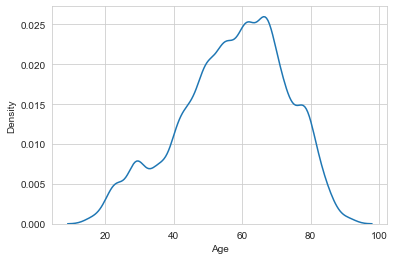

In [80]:
sns.set_style('whitegrid')
sns.kdeplot(df.Age, bw_method=0.15) # plot age using seaborn

In [81]:
df.isnull().sum() # check number of NaNs per variable

Age          0
Male         0
Female       0
ECTDiagn1    0
ECTDiagn2    0
            ..
EMGtotal     0
EEGtotal     0
MoodBEF2     0
CognBEF2     0
PreSPIC      0
Length: 62, dtype: int64

In [82]:
## train_test split

X = df.drop(columns = ['PreSPIC']).copy()
y = df['PreSPIC']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

In [83]:
df.dtypes

Age          float64
Male         float64
Female       float64
ECTDiagn1      int64
ECTDiagn2      int64
              ...   
EMGtotal     float64
EEGtotal     float64
MoodBEF2     float64
CognBEF2     float64
PreSPIC        int64
Length: 62, dtype: object

In [84]:
xgb_model = xgb.XGBClassifier()

In [93]:
#from https://www.kaggle.com/phunter/xgboost-with-gridsearchcv

#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.001], #so called `eta` value
              'max_depth': [4,5,6,7,8],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [1000], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'use_label_encoder':[False],
              'seed': [1337],
              'verbosity': [0]}

In [94]:
clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=None, 
                   scoring='roc_auc', refit=True)

In [95]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None...
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.001],
                         'max_depth': [4, 5, 6, 7, 8], 'min_c

In [96]:
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=4,
              min_child_weight=11, missing=-999, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=1337, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=1337, silent=1, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

In [97]:
clf.best_score_

0.5702457002457002

In [98]:
clf.cv_results_

{'mean_fit_time': array([1.11182146, 1.11714511, 1.1247108 , 1.03561769, 1.31116357]),
 'std_fit_time': array([0.0501174 , 0.05746439, 0.06233878, 0.05020052, 0.05502277]),
 'mean_score_time': array([0.00269623, 0.00291376, 0.00241294, 0.0024713 , 0.00237584]),
 'std_score_time': array([3.07398443e-04, 9.00688813e-04, 6.13551765e-05, 9.92605697e-05,
        6.12844279e-05]),
 'param_colsample_bytree': masked_array(data=[0.7, 0.7, 0.7, 0.7, 0.7],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.001, 0.001, 0.001, 0.001, 0.001],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[4, 5, 6, 7, 8],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[11, 11, 11, 11, 11],
              mask=[False